# Comparative analysis of KANs, MLPs and SVMs

In [1]:
%matplotlib inline
import numpy as np
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
import matplotlib.pyplot as plt
from utils.activations import tanh_act, relu, sigmoid_act
from utils.edge_fun import get_bsplines
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn import datasets

folder_fig = './'

color_plots = {'dataset': 'b',
               'kan': 'orange',
               'mlp': 'green',
               'svm': 'red'
               }


## **1D regression**

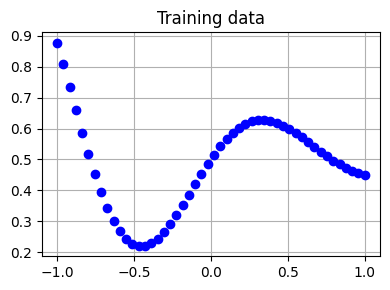

In [2]:
x_train = np.linspace(-1, 1, 50).reshape(-1, 1)
y_train = .5 * np.sin(4 * x_train) * np.exp(-(x_train+1)) + .5  # damped sinusoid

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'])
ax.set_title('Training data')
ax.grid()
fig.tight_layout()

## Training
### Parameters

In [3]:
n_iter_train_1d = 500
loss_tol_1d = .05
seed = 476

### KAN

In [4]:
kan_1d = FeedForward([1, 2, 2, 1],  # layer size
                  eps=.01,  # gradient descent parameter
                  n_weights_per_edge=7,  # n. edge functions
                  neuron_class=NeuronKAN, 
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train, 
          y_train, 
          n_iter_max=n_iter_train_1d, 
          loss_tol=loss_tol_1d)

  0%|          | 1/500 [00:00<01:19,  6.25it/s, loss: 19.783]

 19%|█▉        | 95/500 [00:10<00:43,  9.39it/s, loss: 0.049. Convergence has been attained!]


### MLP

In [5]:
mlp_1d = FeedForward([1, 17, 1],  # layer size
                  eps=.005,  # gradient descend parameter
                  activation=relu,  # activation type (ReLU, tanh or sigmoid)
                  neuron_class=NeuronNN, 
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train, 
             y_train, 
             n_iter_max=n_iter_train_1d, 
             loss_tol=loss_tol_1d)

 81%|████████  | 405/500 [00:18<00:04, 22.00it/s, loss: 0.050. Convergence has been attained!]


In [6]:
# Initialize and train the SVM regressor
svm_regressor = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_regressor.fit(x_train, y_train)

# Make predictions
y_pred = svm_regressor.predict(x_train)

# Calculate the accuracy (R² score)
accuracy = svm_regressor.score(x_train, y_train)

# Calculate the loss (Mean Squared Error)
loss = mean_squared_error(y_train, y_pred)

# Print the results
print(f"Accuracy (R² score): {accuracy:.4f}")
print(f"Loss (Mean Squared Error): {loss:.4f}")

# Calculate the SVM loss (Mean Squared Error) after training
y_svm_pred = svm_regressor.predict(x_train)
svm_loss = mean_squared_error(y_train, y_svm_pred)

Accuracy (R² score): 0.7986
Loss (Mean Squared Error): 0.0049


/home/ayush/Desktop/KAN/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# Regression Test Set
x_test = np.linspace(-1, 1, 100).reshape(-1, 1)  # Test data
y_test = .5 * np.sin(4 * x_test) * np.exp(-(x_test+1)) + .5  # True test labels

# Predictions
y_pred_kan_test = np.array([kan_1d(x) for x in x_test])
y_pred_mlp_test = np.array([mlp_1d(x) for x in x_test])
y_pred_svm_test = svm_regressor.predict(x_test)

# Calculate Test MSE
mse_kan = mean_squared_error(y_test, y_pred_kan_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp_test)
mse_svm = mean_squared_error(y_test, y_pred_svm_test)

# Print Regression Test Results
print(f"Regression Test MSE:")
print(f"KAN: {mse_kan:.4f}, MLP: {mse_mlp:.4f}, SVM: {mse_svm:.4f}")

Regression Test MSE:
KAN: 0.0009, MLP: 0.0010, SVM: 0.0048


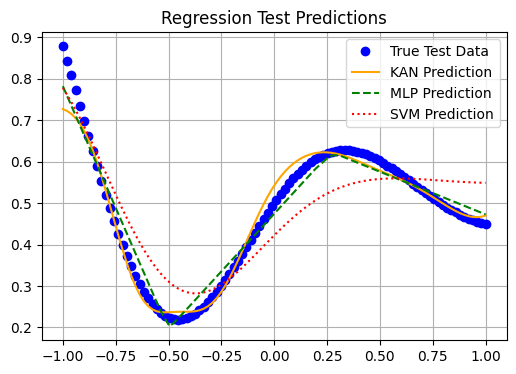

In [8]:
# Plot Test Predictions for Regression
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x_test, y_test, 'o', color=color_plots['dataset'], label='True Test Data')
ax.plot(x_test, y_pred_kan_test, '-', color=color_plots['kan'], label='KAN Prediction')
ax.plot(x_test, y_pred_mlp_test, '--', color=color_plots['mlp'], label='MLP Prediction')
ax.plot(x_test, y_pred_svm_test, ':', color=color_plots['svm'], label='SVM Prediction')
ax.set_title("Regression Test Predictions")
ax.legend()
ax.grid()
plt.show()

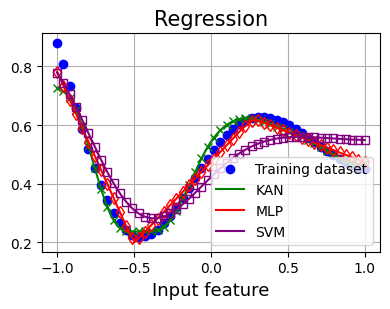

In [9]:
# Generate a dense grid of x values for smooth predictions
x_plot = np.linspace(x_train[0], x_train[-1], 1000).reshape(-1, 1)

# Generate SVM predictions
y_svm_pred = svm_regressor.predict(x_plot)

# Plot
fig, ax = plt.subplots(figsize=(4, 3.2))

# Plot training dataset points
ax.plot(x_train, y_train, 'o', color='blue', label='Training dataset')

# Plot KAN predictions (using x_train and x_plot)
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color='green', label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color='green', fillstyle='none')

# Plot MLP predictions (using x_train and x_plot)
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color='red', label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color='red', fillstyle='none')

# Plot SVM predictions (using x_plot and x_train)
ax.plot(x_plot, y_svm_pred, color='purple', label='SVM')
ax.plot(x_train, svm_regressor.predict(x_train), 's', color='purple', fillstyle='none')

# Set labels and title
ax.set_xlabel('Input feature', fontsize=13)
ax.set_title('Regression', fontsize=15)

# Show legend and grid
ax.legend()
ax.grid()

# Tight layout and show plot
fig.tight_layout()
plt.show()

### Loss evolution

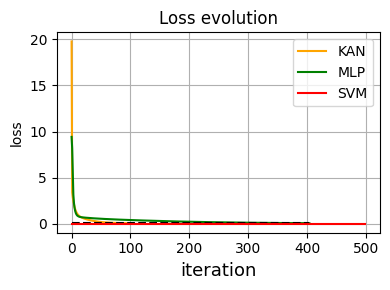

In [10]:
fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_1d.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_1d.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_1d * np.ones(max(len(mlp_1d.loss_hist), len(kan_1d.loss_hist))), '--k')
svm_loss_history = [svm_loss] * 500
ax1.plot(svm_loss_history, '-', color='red', label='SVM')
ax1.grid()
ax1.set_ylabel('loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
fig1.tight_layout()
plt.show()

## **Classification**

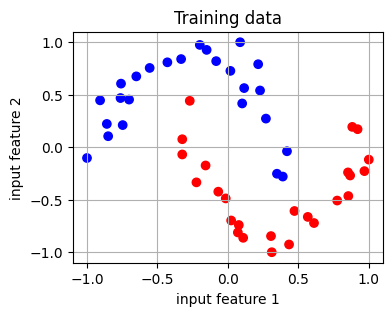

In [11]:
n_samples = 50
noise = 0.1
x_train_cl, y_train_cl = datasets.make_moons(n_samples=n_samples, noise=noise)
# normalize between -1 and 1
x_train_cl[:, 0] = (x_train_cl[:, 0] - min(x_train_cl[:, 0])) / max(x_train_cl[:, 0] - min(x_train_cl[:, 0])) * 2 - 1
x_train_cl[:, 1] = (x_train_cl[:, 1] - min(x_train_cl[:, 1])) / max(x_train_cl[:, 1] - min(x_train_cl[:, 1])) * 2 - 1

fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax.set_xlabel('input feature 1')
ax.set_ylabel('input feature 2')
ax.grid()
ax.set_title("Training data")
plt.show()

## Training
### Parameters

In [12]:
n_iter_train_cl = int(1e3)
loss_tol_cl = 1.5
seed = 476

### KAN

In [13]:
from loss.cross_entropy_loss import CrossEntropyLoss

kan_cl = FeedForward([2, 2],  # layer size
                     eps=.02,  # gradient descent parameter
                     n_weights_per_edge=8,  # n. edge functions
                     neuron_class=NeuronKAN, 
                     loss=CrossEntropyLoss,
                     x_bounds=[-1, 1],  # input domain bounds
                     get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                     seed=seed,
                     weights_range=[-1, 1])
kan_cl.train(x_train_cl, 
             y_train_cl.reshape(-1, 1), 
             n_iter_max=n_iter_train_cl, 
             loss_tol=loss_tol_cl)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:32<00:00, 30.61it/s, loss: 6.927]


### MLP

In [14]:
mlp_cl = FeedForward([2, 10, 10, 2],  # layer size
                     eps=.01,  # gradient descend parameter
                     activation=tanh_act,  # activation type (relu, tanh_act or sigmoid_act)
                     neuron_class=NeuronNN, 
                     loss=CrossEntropyLoss,
                     seed=seed, 
                     weights_range=[-1, 1])
mlp_cl.train(x_train_cl, 
             y_train_cl.reshape(-1, 1), 
             n_iter_max=n_iter_train_cl, 
             loss_tol=loss_tol_cl)

100%|██████████| 1000/1000 [00:41<00:00, 23.84it/s, loss: 6.446]


### SVM(State Vector Machine)

In [15]:
# Create and train the SVM model
svm_clf = SVC(kernel='rbf', C=1, gamma=0.5)  # Using RBF kernel with regularization
svm_clf.fit(x_train_cl, y_train_cl)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = x_train_cl[:, 0].min() - 0.1, x_train_cl[:, 0].max() + 0.1
y_min, y_max = x_train_cl[:, 1].min() - 0.1, x_train_cl[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict on grid points to plot decision boundary for SVM
Z_svm = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)



In [16]:
def softmax(vec):
    return np.exp(vec) / sum(np.exp(vec))

# Classification Test Set
x_test_cl, y_test_cl = datasets.make_moons(n_samples=100, noise=noise)
x_test_cl[:, 0] = (x_test_cl[:, 0] - min(x_test_cl[:, 0])) / max(x_test_cl[:, 0] - min(x_test_cl[:, 0])) * 2 - 1
x_test_cl[:, 1] = (x_test_cl[:, 1] - min(x_test_cl[:, 1])) / max(x_test_cl[:, 1] - min(x_test_cl[:, 1])) * 2 - 1

# Predictions
y_pred_kan_cl = np.array([np.argmax(softmax(kan_cl(x))) for x in x_test_cl])
y_pred_mlp_cl = np.array([np.argmax(softmax(mlp_cl(x))) for x in x_test_cl])
y_pred_svm_cl = svm_clf.predict(x_test_cl)

# Calculate Accuracy
accuracy_kan = np.mean(y_pred_kan_cl == y_test_cl)
accuracy_mlp = np.mean(y_pred_mlp_cl == y_test_cl)
accuracy_svm = np.mean(y_pred_svm_cl == y_test_cl)

# Print Classification Test Results
print(f"Classification Test Accuracy:")
print(f"KAN: {accuracy_kan:.4f}, MLP: {accuracy_mlp:.4f}, SVM: {accuracy_svm:.4f}")


Classification Test Accuracy:
KAN: 1.0000, MLP: 0.9800, SVM: 0.8900


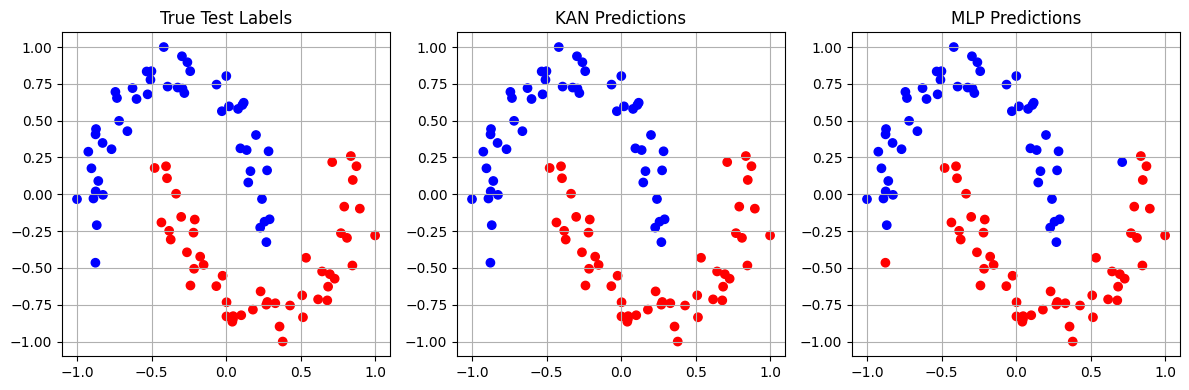

In [17]:
# Classification Test Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(*x_test_cl.T, c=y_test_cl, cmap=plt.cm.bwr, label='True Labels')
ax[0].set_title("True Test Labels")
ax[0].grid()

ax[1].scatter(*x_test_cl.T, c=y_pred_kan_cl, cmap=plt.cm.bwr, label='KAN Predictions')
ax[1].set_title("KAN Predictions")
ax[1].grid()

ax[2].scatter(*x_test_cl.T, c=y_pred_mlp_cl, cmap=plt.cm.bwr, label='MLP Predictions')
ax[2].set_title("MLP Predictions")
ax[2].grid()

plt.tight_layout()
plt.show()

## Plots

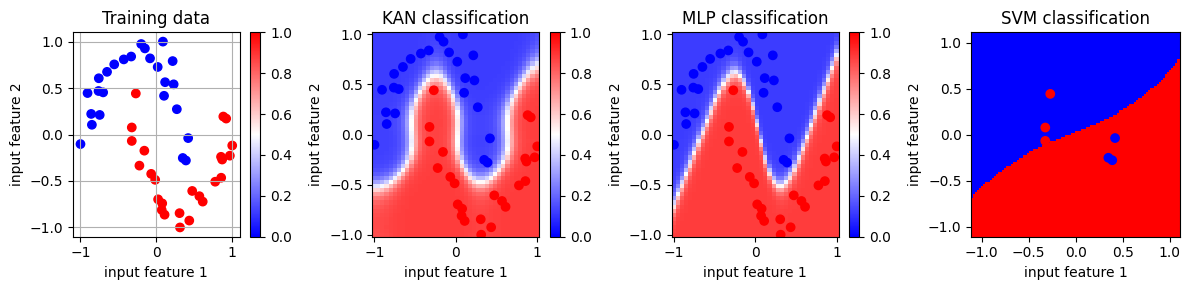

In [18]:
def softmax(vec):
    return np.exp(vec) / sum(np.exp(vec))

X1_cl, X2_cl = np.meshgrid(np.linspace(-1, 1, 40), np.linspace(-1, 1, 50))
x_cl = np.concatenate((X1_cl.reshape(-1, 1), X2_cl.reshape(-1, 1)), axis=1)

Y_kan_cl = np.array([softmax(kan_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)
Y_mlp_cl = np.array([softmax(mlp_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)

fig_cl, ax_cl = plt.subplots(1, 4, figsize=(12,3))
# vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

ax_cl[0].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[0].grid()
ax_cl[0].set_title('Training data')
ax_cl[0].set_xlabel('input feature 1')
ax_cl[0].set_ylabel('input feature 2')

im0 = ax_cl[1].pcolor(X1_cl, X2_cl, Y_kan_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[1].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[1].set_title('KAN classification')
ax_cl[1].set_xlabel('input feature 1')
ax_cl[1].set_ylabel('input feature 2')

im1 = ax_cl[2].pcolor(X1_cl, X2_cl, Y_mlp_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[2].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[2].set_title('MLP classification')
ax_cl[2].set_xlabel('input feature 1')
ax_cl[2].set_ylabel('input feature 2')

# Plot SVM classification decision boundary
im2 = ax_cl[3].pcolor(xx, yy, Z_svm, vmin=0, vmax=1, cmap=plt.cm.bwr)  # SVM Decision Boundary
ax_cl[3].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[3].set_title('SVM classification')
ax_cl[3].set_xlabel('input feature 1')
ax_cl[3].set_ylabel('input feature 2')

fig_cl.colorbar(im1, ax=ax_cl[0])
fig_cl.colorbar(im1, ax=ax_cl[1])
fig_cl.colorbar(im1, ax=ax_cl[2])
fig_cl.tight_layout()
plt.show()
# fig_cl.savefig(folder_fig + 'classification.png', dpi=500)

In [19]:
class IterativeSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.loss_history_ = []
        
    def _compute_loss(self, X, y, w, b):
        # Compute margins
        margins = y * (np.dot(X, w) + b)
        
        # Hinge loss
        hinge_losses = np.maximum(0, 1 - margins)
        empirical_loss = np.mean(hinge_losses)
        
        # Regularization loss
        reg_loss = 0.5 * self.lambda_param * np.sum(w ** 2)
        
        # Total loss
        total_loss = empirical_loss + reg_loss
        
        return empirical_loss, reg_loss, total_loss
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.w_ = np.zeros(n_features)
        self.b_ = 0
        
        # Convert labels to {-1, 1}
        y = np.where(y <= 0, -1, 1)
        
        # Lists to store loss history
        self.loss_history_ = []
        
        for iteration in range(self.n_iterations):
            # Compute current loss
            empirical_loss, reg_loss, total_loss = self._compute_loss(X, y, self.w_, self.b_)
            self.loss_history_.append({
                'iteration': iteration,
                'empirical_loss': empirical_loss,
                'reg_loss': reg_loss,
                'total_loss': total_loss
            })
            
            # Compute gradients for all samples
            margins = y * (np.dot(X, self.w_) + self.b_)
            mask = margins < 1
            
            # Update weights
            dw = self.lambda_param * self.w_ - np.mean(X[mask] * y[mask, np.newaxis], axis=0)
            db = -np.mean(y[mask])
            
            # Apply updates
            self.w_ -= self.learning_rate * dw
            self.b_ -= self.learning_rate * db
            
        return self
    
    def predict(self, X):
        scores = np.dot(X, self.w_) + self.b_
        return np.where(scores >= 0, 1, -1)

def plot_loss_history(svm_model):
    """Plot the loss history over iterations"""
    if not hasattr(svm_model, 'loss_history_') or not svm_model.loss_history_:
        raise ValueError("Model hasn't been trained with loss tracking")
    
    # Extract loss values
    iterations = [x['iteration'] for x in svm_model.loss_history_]
    empirical_losses = [x['empirical_loss'] for x in svm_model.loss_history_]
    reg_losses = [x['reg_loss'] for x in svm_model.loss_history_]
    total_losses = [x['total_loss'] for x in svm_model.loss_history_]
    
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, total_losses, label='Total Loss', color='#e74c3c', linewidth=2)
    
    plt.title('SVM Loss Components Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add log scale option for y-axis if losses vary widely
    if max(total_losses) / min(total_losses) > 100:
        plt.yscale('log')
    
    plt.show()

svm_clf = IterativeSVM(learning_rate=0.01, lambda_param=0.01, n_iterations=1000)
svm_clf.fit(x_train_cl, y_train_cl)

# Plot the loss history
# plot_loss_history(svm_clf)


IterativeSVM()

### Loss evolution

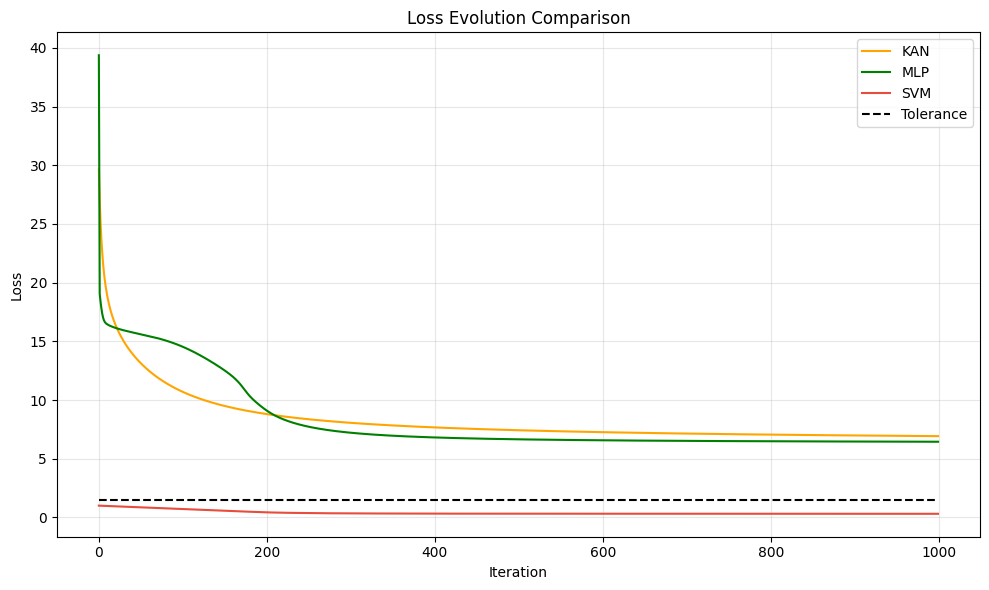

In [20]:
def plot_combined_loss(svm_model, kan_cl, mlp_cl, color_plots, loss_tol_cl):
    # Extract SVM losses
    iterations = [x['iteration'] for x in svm_model.loss_history_]
    total_losses = [x['total_loss'] for x in svm_model.loss_history_]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot losses for each model
    ax.plot(kan_cl.loss_hist, '-', color=color_plots['kan'], label='KAN')
    ax.plot(mlp_cl.loss_hist, '-', color=color_plots['mlp'], label='MLP')
    ax.plot(iterations, total_losses, '-', color='#e74c3c', label='SVM')
    
    # Plot tolerance line
    max_iterations = max(len(mlp_cl.loss_hist), len(kan_cl.loss_hist), len(iterations))
    ax.plot(loss_tol_cl * np.ones(max_iterations), '--k', label='Tolerance')
    
    # Customize plot
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    ax.legend()
    ax.set_title('Loss Evolution Comparison')
    
    # Optional: Set y-axis to log scale if losses vary widely
    if max(total_losses) / min(total_losses) > 100:
        ax.set_yscale('log')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_combined_loss(svm_clf, kan_cl, mlp_cl, color_plots, loss_tol_cl)